In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import random
import matplotlib.pyplot as plt
import collections
from scipy.optimize import fsolve

In [2]:
current = pd.to_datetime("2022-02-25")
expire = pd.to_datetime("2022-03-18")
r = 0.0025
coupon = 0.0053
b = r - coupon
days = (expire - current).days
t = days / 365
s = 164.85
underlyings = [i for i in range(150, 181)]
x = 0
put = 0
call = 0

In [3]:
def call_put(s, x, b, r, sig, t):
    d1 = (np.log(s/x) + t*(sig**2/2 + b))/(sig*(t**0.5))
    d2 = d1 - sig * (t**0.5)
    call = s*np.e**((b-r)*t)*norm.cdf(d1) - x*np.e**(-r*t)*norm.cdf(d2)
    put = x*np.e**(-r*t)*norm.cdf(-d2) - s*np.e**((b-r)*t)*norm.cdf(-d1)
    return call, put

def funcput(sig):
    return x*np.e**(-r*t)*norm.cdf(-((np.log(s/x) + t*(sig**2/2 + b))/(sig*(t**0.5)) - sig * (t**0.5))) - s*np.e**((b-r)*t)*norm.cdf(-(np.log(s/x) + t*(sig**2/2 + b))/(sig*(t**0.5))) - put

def funcall(sig):
    return s*np.e**((b-r)*t)*norm.cdf((np.log(s/x) + t*(sig**2/2 + b))/(sig*(t**0.5))) - x*np.e**(-r*t)*norm.cdf((np.log(s/x) + t*(sig**2/2 + b))/(sig*(t**0.5)) - sig * (t**0.5)) - call

In [4]:
def helper(ty, pos, opt, strike, val, l):
    global x, put, call
    rtn = [0] * l
    if ty == "Stock":
        for i in range(l):
            rtn[i] = pos * (underlyings[i] - val)
    elif opt == "Call":
        x = strike
        call = val
        sig = fsolve(funcall, 0.8)[0]
        for i in range(l):
            rtn[i] = pos * (call_put(underlyings[i], x, b ,r,sig, t)[0] - val)
    else:
        x = strike
        put = val
        sig = fsolve(funcall, 0.8)[0]
        for i in range(l):
            rtn[i] = pos * (call_put(underlyings[i], x, b ,r,sig, t)[1] - val)
    return rtn

In [5]:
ps = np.array(pd.read_csv("./problem3.csv"))
dic = collections.defaultdict()
for line in ps:
    name = line[0]
    if name not in dic:
        dic[name] = [0] * len(underlyings)
    temp = helper(line[1], line[3], line[4], line[6], line[7], len(underlyings))
    for i in range(len(underlyings)):
        dic[name][i] += temp[i]

/Users/staceywzy/PycharmProjects/FinTech590-RiskManagement/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


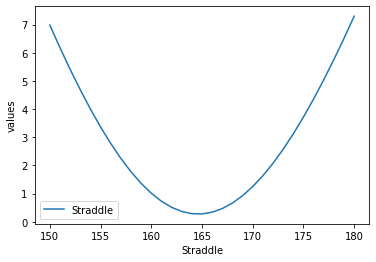

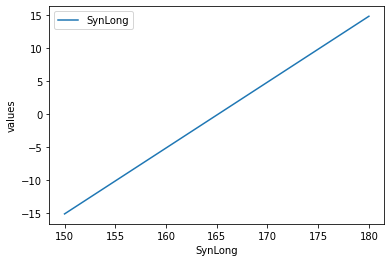

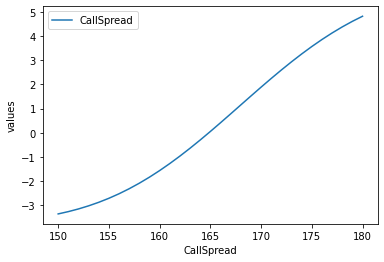

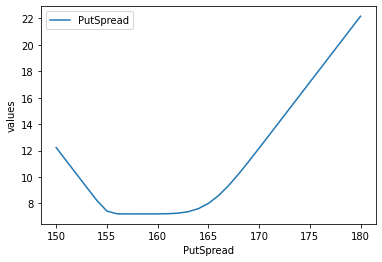

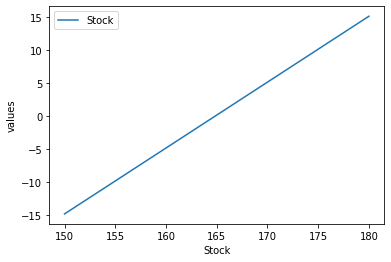

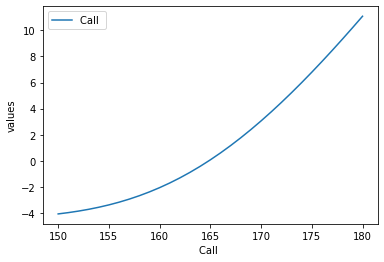

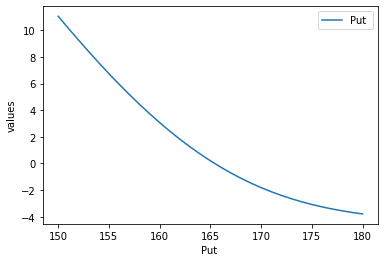

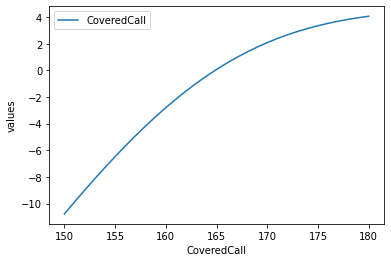

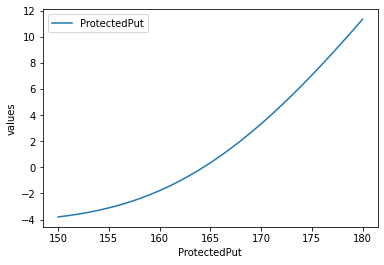

In [6]:
for key in dic:
    plt.clf()
    plt.plot(underlyings, dic[key], label=key)
    plt.xlabel(key)
    plt.ylabel('values')
    plt.legend()
    plt.show()

In [7]:
returns = pd.read_csv("./DailyReturn.csv").AAPL
mu_norm, std_norm = norm.fit(returns)
returns = returns-mu_norm

In [8]:
simulate = np.random.normal(mu_norm, std_norm, 10)

In [9]:
prices = [164.85]
for re in simulate:
    prices.append(prices[-1]/(1+re))
prices = np.array(prices[1:][::-1])

In [10]:
for line in ps:
    name = line[0]
    dic[name] = [0] * len(prices)
    temp = helper(line[1], line[3], line[4], line[6], line[7], len(prices))
    for i in range(len(prices)):
        dic[name][i] += temp[i]

/Users/staceywzy/PycharmProjects/FinTech590-RiskManagement/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [11]:
rtn = pd.DataFrame(None, columns=['Name', 'Mean', 'VaR', 'Es'])
alpha = 0.05
for key in dic:
    values = np.array(dic[key])
    mean = values.mean()
    std = values.std()
    VaR = norm.ppf(alpha, mean, std)
    es = alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean
    rtn.loc[len(rtn.index)] = [key, mean, VaR, es] 
rtn
    

,Name,Mean,VaR,Es
0,Straddle,7.252757,3.405397,-2.428012
1,SynLong,-7.252757,-11.100118,12.077503
2,CallSpread,0.655643,0.568163,-0.545939
3,PutSpread,2.609842,0.322668,0.258366
4,Stock,-10.350000,-15.074482,16.274691
5,Call,-3.370616,-4.261056,4.487264
6,Put,7.252757,3.405397,-2.428012
7,CoveredCall,3.370616,2.480176,-2.253969
8,ProtectedPut,7.252757,3.405397,-2.428012
